In [1]:
!pip install h5netcdf
#!wget https://s3.eu-central-1.wasabisys.com/melody/Blocky_AnDA.ncdf -O "dataset.ncdf"
!wget https://s3.eu-central-1.wasabisys.com/melody/Blocky_AnDA_OSMOSIS.ncdf -O "osmosis.ncdf"
!wget https://s3.eu-central-1.wasabisys.com/melody/saved_path_OSMOSIS.pickle -O "osmosis_test.pickle"
!wget https://s3.eu-central-1.wasabisys.com/melody/Blocky_AnDA_GULFSTREAM.ncdf -O "gulfstream.ncdf"
!wget https://s3.eu-central-1.wasabisys.com/melody/saved_path_GULFSTREAM.pickle -O "gulfstream_test.pickle"

--2020-06-19 01:05:00--  https://s3.eu-central-1.wasabisys.com/melody/Blocky_AnDA_OSMOSIS.ncdf
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.11, 130.117.252.12, 130.117.252.13, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337931889 (322M) [application/octet-stream]
Saving to: ‘osmosis.ncdf’

osmosis.ncdf        100%[===================>] 322.28M  13.6MB/s    in 26s     

2020-06-19 01:05:27 (12.6 MB/s) - ‘osmosis.ncdf’ saved [337931889/337931889]

--2020-06-19 01:05:28--  https://s3.eu-central-1.wasabisys.com/melody/saved_path_OSMOSIS.pickle
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.11, 130.117.252.12, 130.117.252.13, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

#Première méthode : postAnDA

In [2]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.ndimage.morphology import distance_transform_edt as bwdist

def LR_perform(HR, path_LR, N_eof):
    """ Perform global PCA retrieving LR product """
    #if not os.path.exists(path_LR):
    if True:
        lr = np.copy(HR).reshape(HR.shape[0],-1)
        tmp = lr[0,:]
        sea_v2 = np.where(~np.isnan(tmp))[0]
        lr_no_land = lr[:,sea_v2]
        pca = PCA(n_components=N_eof)
        score_global = pca.fit_transform(lr_no_land)
        coeff_global = pca.components_.T
        mu_global = pca.mean_
        print(np.sum(pca.explained_variance_ratio_))
        DataReconstructed_global = np.dot(score_global, coeff_global.T) +mu_global
        lr[:,sea_v2] = DataReconstructed_global
        lr = lr.reshape(HR.shape)
        if not (path_LR == ''):
            fid = netCDF4.Dataset(path_LR,'w', format='NETCDF4')
            fid.createDimension('lat', HR.shape[1])
            fid.createDimension('lon', HR.shape[2])
            fid.createDimension('time', HR.shape[0])
            fid.createVariable("lr", "f8",("time","lat", "lon"),fill_value=-32768,zlib=True)
            fid.variables['lr'][:] = lr
            fid.close()
    else:
        file_tmp = netCDF4.Dataset(path_LR,'r')
        lr = file_tmp.variables['lr'][:]
        file_tmp.close()
    return lr
    
def sum_overlapping(tmp1,tmp2):
    """ calculate overlapping area between patches  """
    bw = np.zeros(tmp1.shape)
    D = bwdist(bw==0)
    D = np.exp(-D)
    w1 = np.nan*np.zeros(tmp1.shape)
    w2 = np.nan*np.zeros(tmp1.shape)
    w2[:,0:5] = np.fliplr(D[:,0:5])
    w2[0:5,4:] = np.flipud(D[0:5,4:])
    w1[:,0:5] = D[:,0:5]
    w1[0:5,4:] = D[0:5,4:]
    wsum = w1+w2
    w1 = w1/wsum
    w2 = w2/wsum
    tmp2[~np.isnan(tmp2)] = 2*tmp2[~np.isnan(tmp2)]*w2[~np.isnan(tmp2)]
    tmp1[~np.isnan(tmp2)] = 2*tmp1[~np.isnan(tmp2)]*w1[~np.isnan(tmp2)]
    overlap = np.array([tmp2,tmp1])
    overlap = np.nanmean(overlap,axis=0)
    return overlap
    
def Post_process(Pre_filtered, L, size_w, n_eof):
    """ Remove block artifact due to overlapping patches """
    Post_filtered =  np.nan*np.zeros((L,Pre_filtered.shape[1],Pre_filtered.shape[2]))
    r_sub = np.arange(0,size_w)
    c_sub = np.arange(0,size_w)
    ind = 0
    while (len(r_sub)>0):
        while (len(c_sub)>0):
            tmp = Pre_filtered[:,r_sub[0]:r_sub[-1]+1,c_sub[0]:c_sub[-1]+1]
            tmp = tmp.reshape(tmp.shape[0],-1)
            sea_mask = np.where(~np.isnan(tmp[0,:]))[0]
            tmp_no_land = tmp[:,sea_mask]
            if (len(sea_mask)>0):
                pca = PCA(n_components=len(sea_mask))
                if (len(sea_mask)>n_eof):
                    pca = PCA(n_components=n_eof)
                score_tmp = pca.fit_transform(tmp_no_land)
                coeff_tmp = pca.components_.T
                mu_tmp = pca.mean_
                DataReconstructed_tmp = np.dot(score_tmp, coeff_tmp.T) +mu_tmp
                tmp[:,sea_mask] = DataReconstructed_tmp
                for u in range(0,L):
                    tmp2 = Post_filtered[u,r_sub[0]:r_sub[-1]+1,c_sub[0]:c_sub[-1]+1]
                    tmp1 = tmp[Pre_filtered.shape[0]-L+u,:].reshape(tmp2.shape)
                    Post_filtered[u,r_sub[0]:r_sub[-1]+1,c_sub[0]:c_sub[-1]+1] = sum_overlapping(tmp1,tmp2)
                ind = ind+1
            c_sub = c_sub+size_w-5
            c_sub = c_sub[c_sub<Pre_filtered.shape[2]]
        r_sub = r_sub+size_w-5
        r_sub = r_sub[r_sub<Pre_filtered.shape[1]]
        c_sub = np.arange(0,size_w)
    return Post_filtered


def postAnDA(train_x, test_x):
    # First post-processing
    Pre_filtered = np.concatenate((train_x, test_x), axis=0)
    postAnDA     = Post_process(Pre_filtered, len(test_x), 17, 15)
    # Second post-processing
    Pre_filtered = np.concatenate((train_x, postAnDA), axis=0)
    postAnDA     = Post_process(Pre_filtered, len(test_x), 13, 15)
    # Final step
    AnDA         = np.concatenate((train_x, postAnDA), axis=0)
    X_lr         = LR_perform(AnDA,'',100)
    postAnDA     = X_lr[len(train_x):]
    return postAnDA

#Deuxième méthode : Réseau de neurones convolutif

###Définition des fonctions loss


Using TensorFlow backend.


1.0


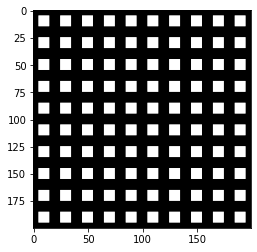

In [3]:
import keras.backend as K

#fonction loss 1 : erreur quadratique
def loss_mse(a, b):
    return K.mean(K.square(a-b), axis=-1)

#fonction loss 2 : erreur quadratique pondérée
def loss_weighted_mse(a, b):
    image_width = K.int_shape(a)[1]
    image_height = K.int_shape(a)[2]
    return K.mean(K.square(a-b), axis=-1) * make_mask(image_width, image_height)

def make_mask(image_width, image_height):
    square_size = 20
    overlap_size = 5
    center_weight = 1
    border_weight = 1.5 #<----- Déterminer la meilleure valeur

    mask = np.zeros((square_size, square_size), dtype=K.floatx())
    mask[:, :] = border_weight
    mask[overlap_size:square_size-overlap_size, overlap_size:square_size-overlap_size] = center_weight
    mask *= square_size**2 / np.sum(mask)
    mask = np.tile(mask, (image_width // square_size, image_height // square_size))
    return K.constant(mask)

from matplotlib import pyplot as plt
print(np.mean(make_mask(200, 200)))
plt.imshow(make_mask(200, 200), cmap="Greys")
plt.show()

###Définition du réseau de neurones

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D

#Redimensionne un tableau de taille (*, longueur, largeur) vers (*, longueur, largeur, 1) et remplace les NaN par 0
def reshape_input(a):
    num_images = a.shape[0]
    image_width, image_height = a.shape[1:3]
    result = a.reshape(num_images, image_width, image_height, 1)
    result[np.isnan(result)] = 0
    return result

def make_cnn(image_width, image_height, lossfn):
    model = Sequential()
    model.add(Conv2D(40, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(image_width, image_height, 1)))
    model.add(Conv2D(40, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(Conv2D(1, kernel_size=(3, 3), padding="same"))
    model.compile(optimizer="adam", loss=lossfn)
    return model

def train_cnn(cnn, train_x, train_y, validation_x, validation_y, **kwargs):
    train_x = reshape_input(train_x)
    train_y = reshape_input(train_y)
    validation_x = reshape_input(validation_x)
    validation_y = reshape_input(validation_y)
    return cnn.fit(train_x, train_y, validation_data=(validation_x, validation_y), **kwargs)

def predict(cnn, x):
    x = reshape_input(x)
    return cnn.predict(x)[:, :, :, 0]

#Tests


In [5]:
from collections import namedtuple
from matplotlib import pyplot as plt
import xarray as xr
import pickle

TestResult = namedtuple("TestResult", [
    "ANDA",
    "GT",
    "predict_postANDA",
    "predict_cnn_mse",
    "predict_cnn_weighted_mse",
    "train_mse_history",
    "train_weighted_mse_history"
])

def rmse(x, y):
    return np.sqrt(np.mean((x-y)**2))

def test_predict(fichier_ncdf, fichier_pickle, epochs):
    #Base d'apprentissage
    data_train = xr.open_dataset(fichier_ncdf, engine="h5netcdf")

    #Base de test
    data_test = pickle.load(open(fichier_pickle, "rb"))

    image_width = data_train.sizes["lat"]
    image_height = data_train.sizes["lon"]

    train_ANDA = data_train.ANDA.values
    train_GT = data_train.GT.values
    test_ANDA = data_test[1]
    test_GT = data_test[0]

    #Prédiction 1: la méthode postAnDA
    predict_postANDA = postAnDA(train_ANDA, test_ANDA)

    #Prédiction 2: cnn + loss_mse
    nn_mse = make_cnn(image_width, image_height, loss_mse)
    print(nn_mse.summary())
    train_mse_history = train_cnn(nn_mse, train_ANDA, train_GT, test_ANDA, test_GT, epochs=epochs)
    predict_cnn_mse = predict(nn_mse, test_ANDA)

    #Prédiction 3: cnn + loss_weighted_mse
    nn_weighted_mse = make_cnn(image_width, image_height, loss_weighted_mse)
    print(nn_weighted_mse.summary())
    train_weighted_mse_history = train_cnn(nn_weighted_mse, train_ANDA, train_GT, test_ANDA, test_GT, epochs=epochs)
    predict_cnn_weighted_mse = predict(nn_weighted_mse, test_ANDA)

    return TestResult(test_ANDA, test_GT, predict_postANDA, predict_cnn_mse, predict_cnn_weighted_mse, train_mse_history, train_weighted_mse_history)

def show_train_history(title, train_history):
    loss = train_history.history["loss"]
    val_loss = train_history.history["val_loss"]
    epochs = np.arange(1, len(loss)+1)

    plt.title(title)
    plt.plot(epochs, loss, label="train")
    plt.plot(epochs, val_loss, label="validation")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(axis="y")
    plt.legend()
    plt.savefig(title)
    plt.show()

def show_test_result(title, test_result):
    show_train_history(title + " mse loss", test_result.train_mse_history)
    show_train_history(title + " weighted mse loss", test_result.train_weighted_mse_history)

    #Root mean squared error pour chaque méthode
    rmse_no_treatment = [rmse(x, y) for x, y in zip(test_result.ANDA, test_result.GT)]
    rmse_postANDA = [rmse(x, y) for x, y in zip(test_result.predict_postANDA, test_result.GT)]
    rmse_cnn_mse = [rmse(x, y) for x, y in zip(test_result.predict_cnn_mse, test_result.GT)]
    rmse_cnn_weighted_mse = [rmse(x, y) for x, y in zip(test_result.predict_cnn_weighted_mse, test_result.GT)]

    print("RMSE=")
    print("sans traitement:", np.mean(rmse_no_treatment))
    print("postAnDA:", np.mean(rmse_postANDA))
    print("cnn + mse:", np.mean(rmse_cnn_mse))
    print("cnn + weighted_mse:", np.mean(rmse_cnn_weighted_mse))

    plt.figure(figsize=(18, 6))
    plt.plot(rmse_no_treatment, label="no treatment")
    plt.plot(rmse_postANDA, label="postAnDA")
    plt.plot(rmse_cnn_mse, label="CNN + mse")
    plt.plot(rmse_cnn_weighted_mse, label="CNN + weighted_mse")
    
    plt.title(title)
    plt.xlabel("time (day)")
    plt.ylabel("RMSE")
    plt.grid(axis="y")
    plt.legend()
    plt.savefig(title)
    plt.show()

###Test sur le jeu de données OSMOSIS

In [6]:
test_result_1 = test_predict("osmosis.ncdf", "osmosis_test.pickle", 25)

0.9939188816975453
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 160, 40)      400       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 160, 40)      14440     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 160, 1)       361       
Total params: 15,201
Trainable params: 15,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
21/21 [==============================] - 2s 116ms/step - loss: 8.9882e-04 - val_loss: 2.3522e-04
Epoch 2/25
21/21 [==============================] - 2s 78ms/step - loss: 2.3646e-04 - val_loss: 2.0343e-04
Epoch 3/25
21/21 [==============================] - 2s 78ms/step - loss: 2.0464e-04 - val_loss: 1.9281e-04
Epoch 4/25
21/21 [==================

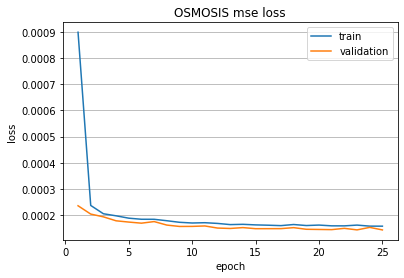

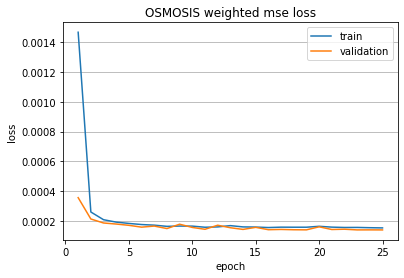

RMSE=
sans traitement: 0.012127382112118834
postAnDA: 0.011610778559662369
cnn + mse: 0.011671284593214478
cnn + weighted_mse: 0.011546689547584772


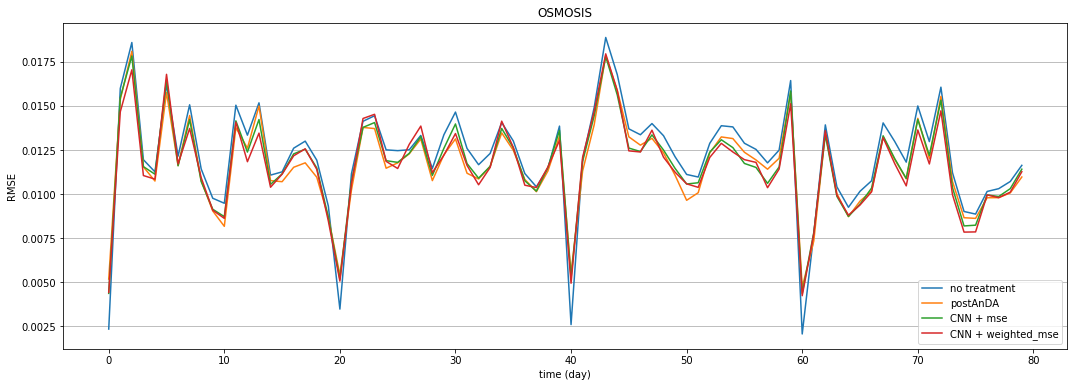

In [7]:
show_test_result("OSMOSIS", test_result_1)

###Test sur le jeu de données GULFSTREAM

In [8]:
test_result_2 = test_predict("gulfstream.ncdf", "gulfstream_test.pickle", 25)

0.9954076418101186
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 200, 200, 40)      400       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 200, 200, 40)      14440     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 200, 200, 1)       361       
Total params: 15,201
Trainable params: 15,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
21/21 [==============================] - 3s 139ms/step - loss: 0.0599 - val_loss: 0.0080
Epoch 2/25
21/21 [==============================] - 2s 97ms/step - loss: 0.0055 - val_loss: 0.0026
Epoch 3/25
21/21 [==============================] - 2s 97ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 4/25
21/21 [==============================] - 2s 96m

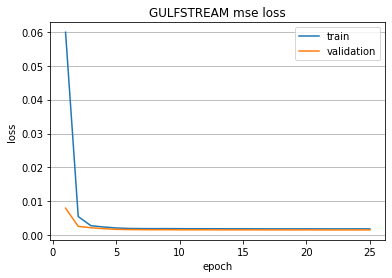

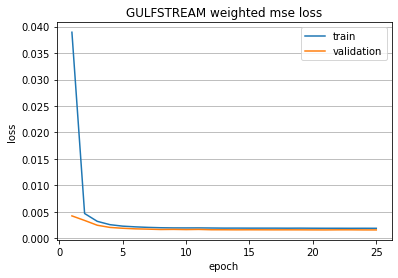

RMSE=
sans traitement: 0.040290295568310534
postAnDA: 0.039111771859171196
cnn + mse: 0.03823941867786501
cnn + weighted_mse: 0.038110138157075514


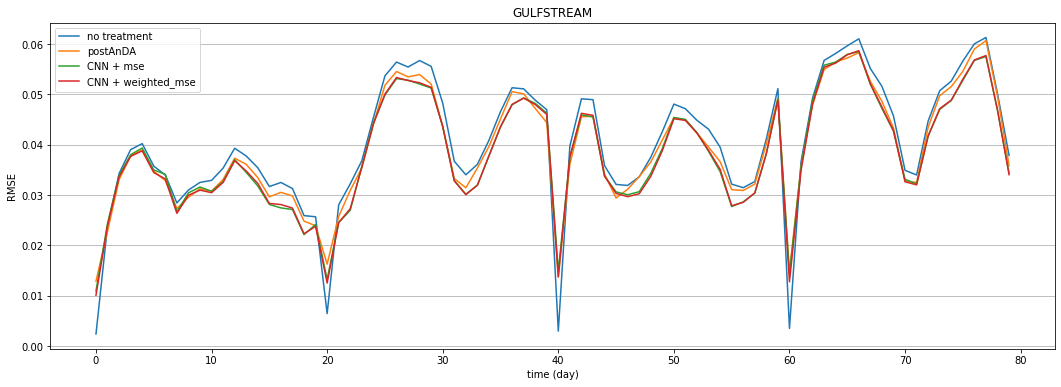

In [9]:
show_test_result("GULFSTREAM", test_result_2)

#Visualisations

In [10]:
def viz(test_result, t):
    plot_args = {
        "vmin": test_result.GT.min(),
        "vmax": test_result.GT.max(),
        "cmap": "RdBu"
    }

    print("RMSE=")
    print("sans traitement:", rmse(test_result.ANDA[t], test_result.GT[t]))
    print("postAnDA:", rmse(test_result.predict_postANDA[t], test_result.GT[t]))
    print("cnn + mse:", rmse(test_result.predict_cnn_mse[t], test_result.GT[t]))
    print("cnn + weighted_mse:", rmse(test_result.predict_cnn_weighted_mse[t], test_result.GT[t]))

    fig, plots = plt.subplots(1, 5, figsize=(24, 6))
    plots = plots.flatten()

    plots[0].set_title("sans traitement")
    fig.colorbar(plots[0].imshow(test_result.ANDA[t], **plot_args), ax=plots)

    plots[1].set_title("GT")
    plots[1].imshow(test_result.GT[t], **plot_args)

    plots[2].set_title("postAnDA")
    plots[2].imshow(test_result.predict_postANDA[t], **plot_args)

    plots[3].set_title("cnn + mse")
    plots[3].imshow(test_result.predict_cnn_mse[t], **plot_args)

    plots[4].set_title("cnn + weighted_mse")
    plots[4].imshow(test_result.predict_cnn_weighted_mse[t], **plot_args)

    plt.show()

RMSE=
sans traitement: 0.015171992001297253
postAnDA: 0.014994646522875334
cnn + mse: 0.014225788899211332
cnn + weighted_mse: 0.01345404805454978


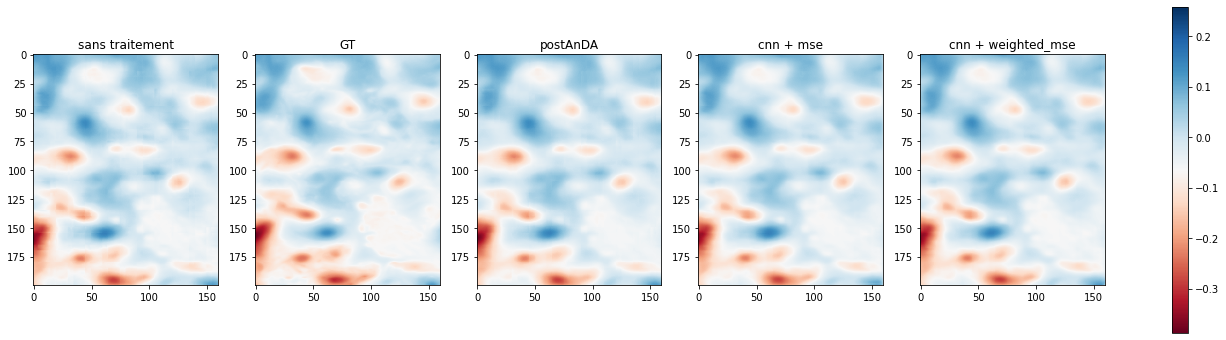

RMSE=
sans traitement: 0.03535739306614059
postAnDA: 0.03310731334424419
cnn + mse: 0.032674564865135036
cnn + weighted_mse: 0.032520165355746505


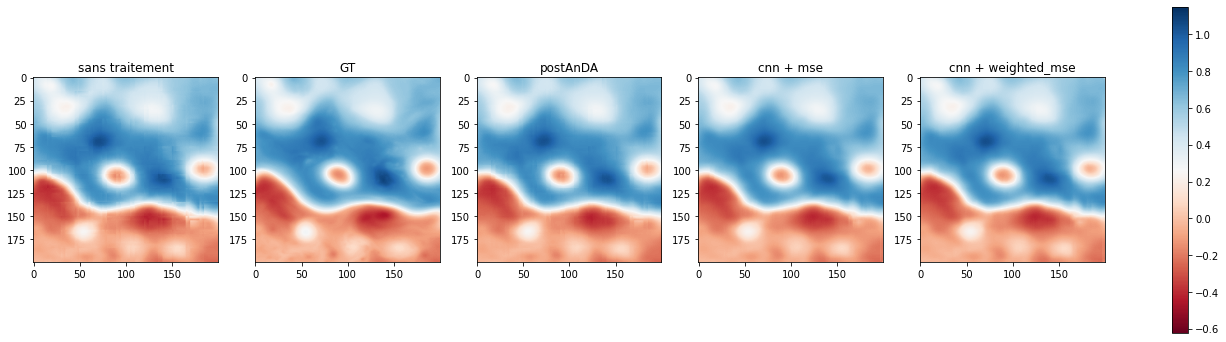

In [11]:
viz(test_result_1, 13)
viz(test_result_2, 11)